# Second Script

#### This is the result from the first script where we compute log-ratio of fractions of frequencies for each pair of residues per a given distance in the table.

In [2]:
# !gdown 1UBkdctgyXQjXZ61OJD532EAMV4Y9cz2U -O results.csv
# Uncomment next line when you want to check results for second file
!gdown 1L9sYOlP9YhF3-qb8IiUgwSjEPJplH5wa -O results.csv

Downloading...
From: https://drive.google.com/uc?id=1L9sYOlP9YhF3-qb8IiUgwSjEPJplH5wa
To: /content/results.csv
100% 1.93k/1.93k [00:00<00:00, 4.88MB/s]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
energies = pd.read_csv('/content/results.csv', index_col=0)
indexes = energies.index.tolist()

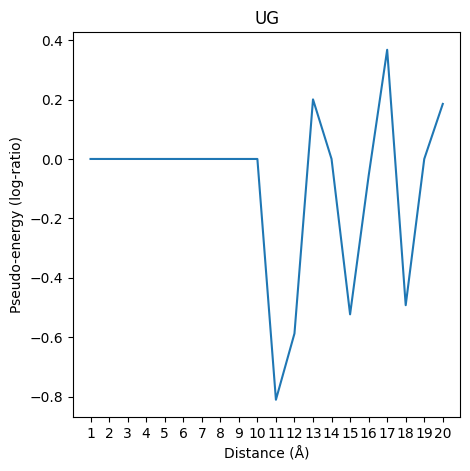

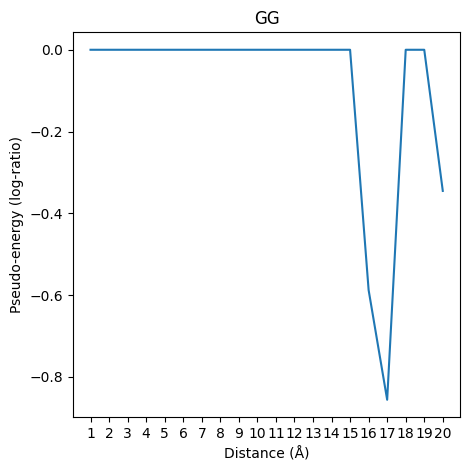

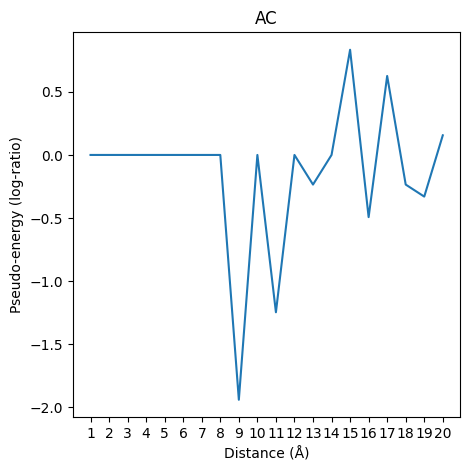

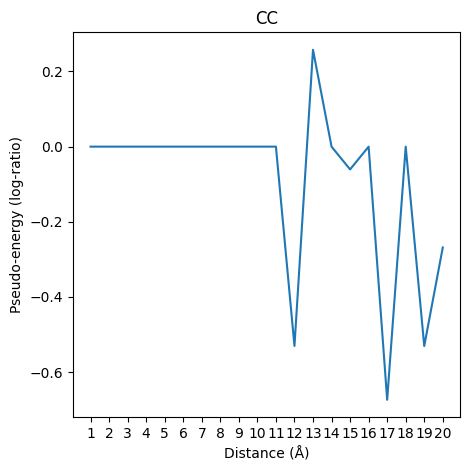

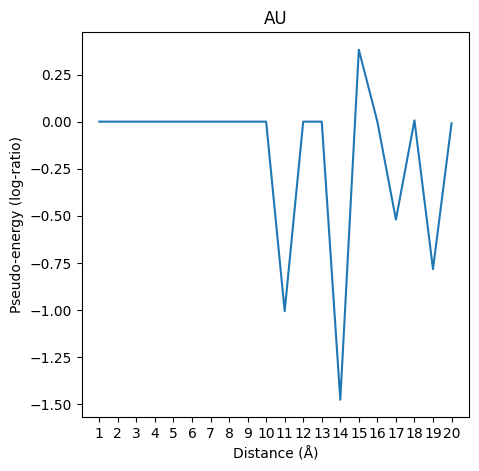

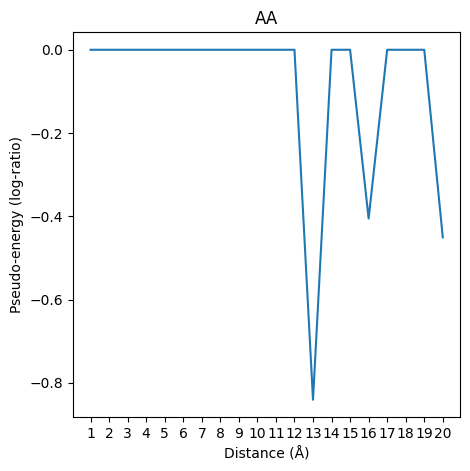

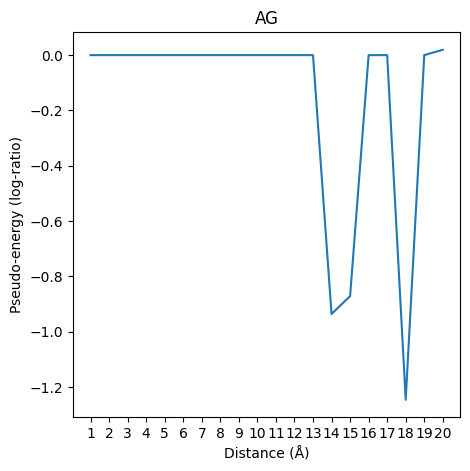

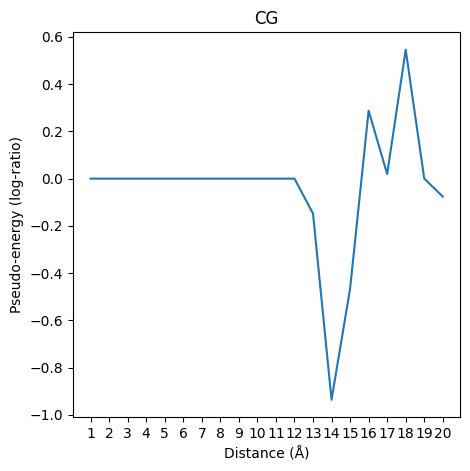

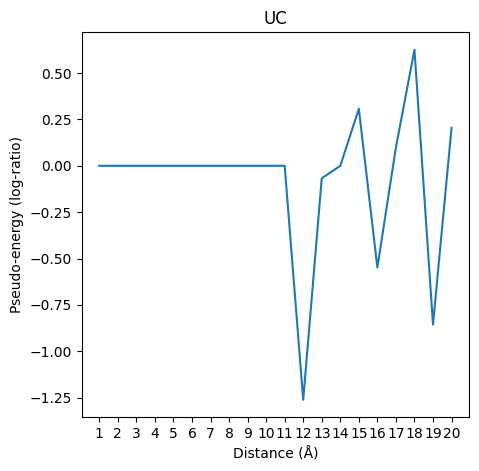

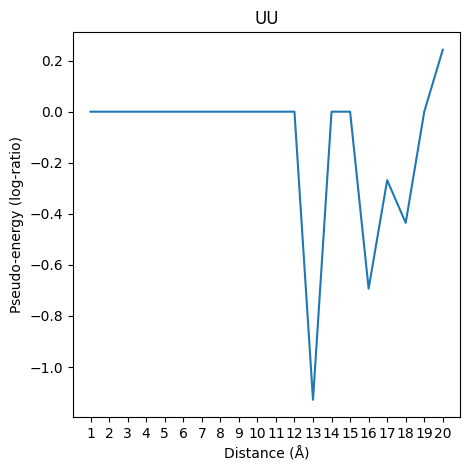

In [5]:
for q in range(energies.shape[0]):
    plt.figure(figsize=(5,5))
    plt.plot(energies.iloc[q,:])
    plt.ylabel("Pseudo-energy (log-ratio)")
    plt.xlabel("Distance (Å)")
    plt.title(indexes[q])

# Third Script

In [6]:
import numpy as np

#### Because we have multiple log-ratios for the same distance the only thing we could do to compute linear interpolation for any given distance - is to compute average of all log ratios for a given distance. Then sum up all these averaged scores from all distances to get a Gibbs free energy. This is what we did.

In [7]:
import numpy as np

def linear_interpolation(x_values, y_values):
    """
    Performz linear interpolation for a set of points.

    Parameters:
    - x_values: List or numpy array of x values
    - y_values: List or numpy array of corresponding y values

    Returns:
    - Function that takes an x value or array and outputs the interpolated y value or array
    """
    x_values, y_values = np.asarray(x_values), np.asarray(y_values)

    def interpolate(x):
        # Find the indices of the closest x values in the given data
        indices = np.searchsorted(x_values, x, side='right')

        # Handle cases where x is beyond the range of provided data
        indices = np.clip(indices, 1, len(x_values) - 1)

        # Linear interpolation formula using numpy array operations
        x0, x1 = x_values[indices - 1], x_values[indices]
        y0, y1 = y_values[indices - 1], y_values[indices]
        return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

    return np.vectorize(interpolate)

Let's see the results of our linear interpolation function on a 100 points on a [1, 20] grid:

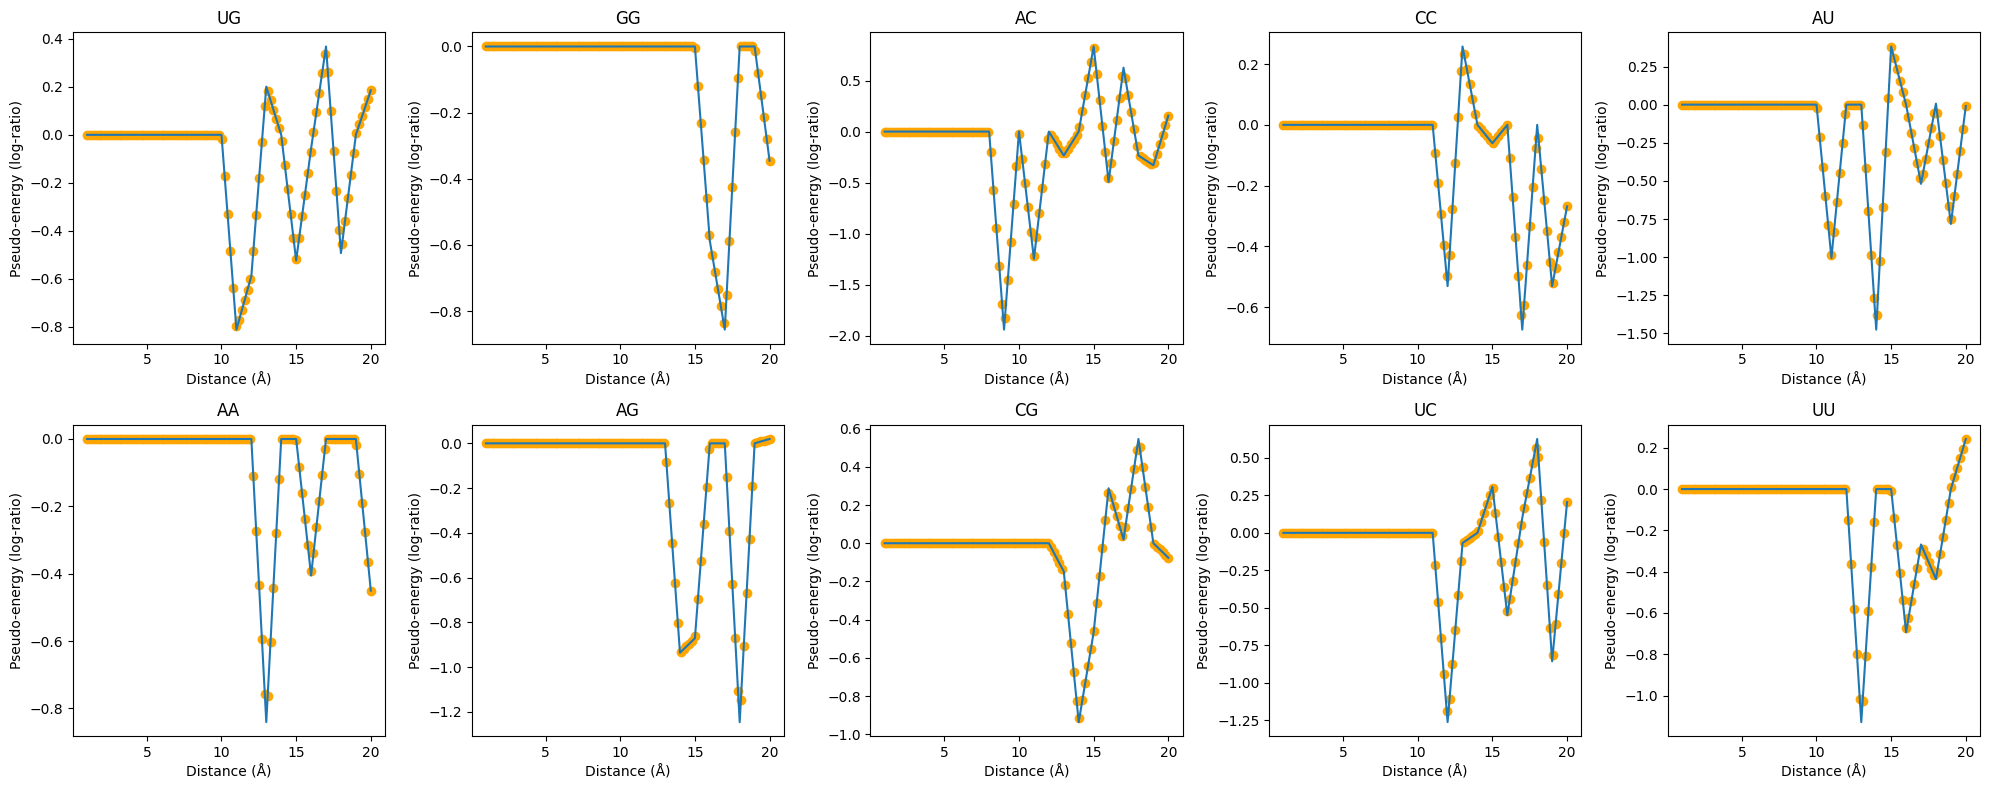

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), squeeze=False)
ax = ax.flatten()

for q in range(energies.shape[0]):
    ax[q].plot(np.arange(1, 21), energies.iloc[q, :])

    interpol = linear_interpolation(x_values=energies.iloc[q].index.astype('float').values, y_values=energies.iloc[q].values)
    interpols = interpol(np.linspace(1, 20, 100))
    ax[q].scatter(x=np.linspace(1, 20, 100), y=interpols, color='orange')

    ax[q].set_ylabel("Pseudo-energy (log-ratio)")
    ax[q].set_xlabel("Distance (Å)")
    ax[q].set_title(indexes[q])

plt.tight_layout()
plt.show()

In [10]:
scores = np.array([])

for q in range(energies.shape[1]):
    # Some sort of linear interpolation for us
    # Because we have same distances for all entries and only different values of log-ratio
    # We compute the average of all log-ratios for the same point =>
    # And the result is the score for the given distance
    scores = np.append(scores, np.sum(energies.iloc[:,q]) / energies.shape[1])

Gibbs_free_energy = np.sum(scores)

In [11]:
Gibbs_free_energy

-1.04312715

### As you may see, the Gibbs fre energy in our case is lower than zero. So the system might not be in equilibrium and changes may occur spontaneously.